# 1 Load Data

## 1.1 Load RNA Data

In [1]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




*Read FeatureCount result*

In [ ]:
BulkRNA_df <- read.table("/home/songqian/Project/Tilapia_Immune/0.RNA/4.count/RNA-Seq_Practice_countstable")
rownames(BulkRNA_df) <- BulkRNA_df$V1
BulkRNA_df <- BulkRNA_df[,2:19]

*Read sample Id*

In [2]:
colnames(BulkRNA_df) <- scan("/home/songqian/Project/Tilapia_Immune/0.RNA/list.txt", what = "character", sep = "\n")
BulkRNA_df <- BulkRNA_df[-1,]
BulkRNA_df[] <- lapply(BulkRNA_df, as.numeric)
head(BulkRNA_df[,1:18],6)

,Cold_HK1,Cold_HK2,Cold_HK3,Cold_SP1,Cold_SP2,Cold_SP3,Cold_TH1,Cold_TH2,Cold_TH3,Ctrl_HK1,Ctrl_HK2,Ctrl_HK3,Ctrl_SP1,Ctrl_SP2,Ctrl_SP3,Ctrl_TH1,Ctrl_TH2,Ctrl_TH3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSONIG00000018423,37,42,36,304,364,281,21,22,40,16,97,19,271,59,403,34,38,20
ENSONIG00000032772,0,3,1,5,4,3,4,3,5,0,4,0,5,5,15,3,1,1
ENSONIG00000007536,0,1,0,1,1,0,0,0,0,0,0,0,0,0,4,0,0,0
ENSONIG00000029674,0,0,1,0,1,0,1,0,0,0,0,0,0,1,1,4,2,0
ENSONIG00000032019,1,0,1,0,0,2,0,1,0,0,2,0,0,0,4,4,5,0
ENSONIG00000033498,59,60,49,51,75,39,48,49,92,13,100,14,85,69,385,88,122,94


In [3]:
featureCounts_meta <- BulkRNA_df[,1:18]
BulkRNA_df <- BulkRNA_df[rowSums(BulkRNA_df)> 0,] 
prefix <- "Tilapia"

In [4]:
RNA_coldata <- data.frame(id = colnames(BulkRNA_df),
                         group = gsub("[0-9]", "", colnames(BulkRNA_df)),
                         condition = stringr::str_split(colnames(BulkRNA_df),pattern = "_",simplify = TRUE)[,1] )

rownames(RNA_coldata) <- RNA_coldata$id
head(RNA_coldata,2)

,id,group,condition
,<chr>,<chr>,<chr>
Cold_HK1,Cold_HK1,Cold_HK,Cold
Cold_HK2,Cold_HK2,Cold_HK,Cold


In [6]:
library(DESeq2)
dds <- DESeqDataSetFromMatrix(countData = BulkRNA_df,
                              colData = RNA_coldata,
                              design = ~ condition)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [7]:
tissue <- c("HK","SP","TH")

In [13]:
smallestGroupSize <- 3
keep <- rowSums(counts(dds) >= 10) >= smallestGroupSize
dds <- dds[keep,]

In [14]:
condition_level <- c("Ctrl","Cold")

### 1.1.1 Find DEGs

In [15]:
DESeq_find_diffgenes <- function(sample_id,Col_data,condition_level){
    print(paste("run",sample_id,sep = ":"))
    sample.id <- grep(sample_id,rownames(Col_data),value=T)
    # For sample_id
    dds.sample <- dds[,sample.id]
    colData(dds.sample) <- droplevels(colData(dds.sample))
    dds.sample$condition <- factor(dds.sample$condition, levels = condition_level )
    design(dds.sample) <- formula(~ condition)
    
    dds.sample <- DESeq(dds.sample)
    #res.sample <- results(dds.sample)
    
    # select the genes which showing differentially expressed in any one of HT time points
    temp <- c("condition_Cold_vs_Ctrl")
    lapply(1:length(temp),function(x){
        res1 <- results(dds.sample, name=temp[x])
        res1.ordered <- as.data.frame(res1[order(res1$pvalue),])
        res1.ordered$gene <- rownames(res1.ordered)
        #res1.ordered$condition <- paste0("HT",x)
        res1.ordered$tissue <- sample_id
        return(res1.ordered)
    }) -> res.sample
    res.sample <- do.call(rbind,res.sample)

    res.list <- list(dds.sample,res.sample)
    return(res.list)
}

In [16]:
tissue_deg_list <- lapply(tissue,DESeq_find_diffgenes,Col_data = RNA_coldata,condition_level)
names(tissue_deg_list) <- tissue

[1] "run:HK"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "run:SP"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "run:TH"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [24]:
DEG.RNA <- do.call(rbind,lapply(tissue_deg_list,'[[',2))
DEG.RNA_2 <- na.omit(DEG.RNA) %>% filter(padj < 0.05) %>% group_by(tissue) %>% arrange(desc(log2FoldChange),.by_group = TRUE)
head(DEG.RNA_2)

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene,tissue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
15.349371,6.732761,1.221477,5.511984,3.548114e-08,1.113293e-06,ENSONIG00000014479,HK
9.273605,5.997890,1.269832,4.723374,2.319638e-06,4.484633e-05,ENSONIG00000042238,HK
8.578649,5.883817,1.290609,4.558946,5.141091e-06,8.950031e-05,ENSONIG00000019199,HK
11.521892,5.544759,1.148675,4.827091,1.385420e-06,2.839257e-05,ENSONIG00000011052,HK
4.971530,5.080199,1.393481,3.645688,2.666774e-04,2.580710e-03,ENSONIG00000008590,HK
4.958700,5.077875,1.386471,3.662446,2.498187e-04,2.442672e-03,ENSONIG00000035414,HK


In [28]:
DEG.RNA_2.list <- split(DEG.RNA_2$gene,DEG.RNA_2$tissue)

In [ ]:
geneID_name <- readRDS("/home/minghao/workbase/gene_annotation/Ensembl_108_Nile_Tilapia/eggnog_geneID2name.rds")
geneID_name <- geneID_name %>% select(gene = Gene.stable.ID,everything())
geneID_name$eggnog_Preferred_name[is.na(geneID_name$eggnog_Preferred_name)] <- "-"
head(geneID_name,2)

In [ ]:
DEG.RNA_3 <- DEG.RNA_2 %>% group_by(gene) %>% left_join(geneID_name,by = "gene") %>% distinct()

In [ ]:
openxlsx::write.xlsx(DEG.RNA,"/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/Bulk_RNA_output/Tilapia_ColdvsCtrl_DEG_RNA_nofilter.xlsx")
openxlsx::write.xlsx(DEG.RNA_3,"/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/Bulk_RNA_output/Tilapia_ColdvsCtrl_DEG_RNA.xlsx")

## 1.2 Load ATAC

In [48]:
library(DiffBind)

 >>> DiffBind 3.8.4



*Read the file containing the paths to the peaks and bam files.* "/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/sample_info_rep.csv"

In [49]:
bulk_atac <- dba(sampleSheet = "/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/sample_info_rep.csv", minOverlap = 3)
atac_df <- read.csv("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/sample_info_rep.csv")
head(atac_df,2)

Cold_HK1 HK ATAC Cold_HK Cold 1 narrow

Cold_HK2 HK ATAC Cold_HK Cold 2 narrow

Cold_SP1 SP ATAC Cold_SP Cold 1 narrow

Cold_SP2 SP ATAC Cold_SP Cold 2 narrow

Cold_TH1 TH ATAC Cold_TH Cold 1 narrow

Cold_TH2 TH ATAC Cold_TH Cold 2 narrow

Ctrl_HK1 HK ATAC Ctrl_HK Ctrl 1 narrow

Ctrl_HK2 HK ATAC Ctrl_HK Ctrl 2 narrow

Ctrl_SP1 SP ATAC Ctrl_SP Ctrl 1 narrow

Ctrl_SP2 SP ATAC Ctrl_SP Ctrl 2 narrow

Ctrl_TH1 TH ATAC Ctrl_TH Ctrl 1 narrow

Ctrl_TH2 TH ATAC Ctrl_TH Ctrl 2 narrow



,SampleID,Tissue,Factor,Condition,Treatment,Replicate,bamReads,Peaks,PeakCaller
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>
1,Cold_HK1,HK,ATAC,Cold_HK,Cold,1,/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/rmDuplicates/Cold_HK1.rmdup.bam,/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/peaks/Cold_HK1_peaks.narrowPeak,narrow
2,Cold_HK2,HK,ATAC,Cold_HK,Cold,2,/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/rmDuplicates/Cold_HK2.rmdup.bam,/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/peaks/Cold_HK2_peaks.narrowPeak,narrow


In [56]:
# 量化数据并获取规范化的百万计数（CPM）
bulk_atac_counts <- dba.count(bulk_atac,score=DBA_SCORE_TMM_READS_EFFECTIVE_CPM,bUseSummarizeOverlaps = TRUE,bParallel=TRUE)

Computing summits...

Re-centering peaks...



In [60]:
atac_diffbind_res <- as.data.frame(bulk_atac_counts$peaks)
atac_diffbind_res.list <- bulk_atac_counts$peaks

In [73]:
names(atac_diffbind_res.list) <- atac_df$SampleID

In [74]:
atac_Deseq2_df <- do.call(cbind,(lapply(atac_diffbind_res.list,function(x) x[,c(1,2,3,6)] )) )

In [75]:
atac_Deseq2_df2 <- atac_Deseq2_df[,seq(4,48,by = 4)][,c(7,8,1,2,9,10,3,4,11,12,5,6)]
colnames(atac_Deseq2_df2) <- gsub("\\.Reads","",colnames(atac_Deseq2_df2))
head(atac_Deseq2_df2,2)

,Ctrl_HK1,Ctrl_HK2,Cold_HK1,Cold_HK2,Ctrl_SP1,Ctrl_SP2,Cold_SP1,Cold_SP2,Ctrl_TH1,Ctrl_TH2,Cold_TH1,Cold_TH2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,53,73,53,89,93,90,99,110,65,34,45,56
2,8,18,8,26,17,20,30,15,12,9,13,14


In [76]:
ATAC_coldata <- data.frame(row.names = colnames(atac_Deseq2_df2),
                           id = colnames(atac_Deseq2_df2),
                          group = gsub("[0-9]","",colnames(atac_Deseq2_df2)),
                          condition = gsub("_.*$","",colnames(atac_Deseq2_df2)) )

In [78]:
dds.atac <- DESeqDataSetFromMatrix(countData = atac_Deseq2_df2,
                              colData = ATAC_coldata,
                              design = ~ condition)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [79]:
tissue
condition_level

[1] "HK" "SP" "TH"

[1] "Ctrl" "Cold"

### 1.2.1 Find DEpeaks

In [80]:
atac.DESeq_find_diffgenes <- function(sample_id,Col_data,condition_level){
    print(paste("run",sample_id,sep = ":"))
    sample.id <- grep(sample_id,rownames(Col_data),value=T)
    # For sample_id
    dds.sample <- dds.atac[,sample.id]
    colData(dds.sample) <- droplevels(colData(dds.sample))
    dds.sample$condition <- factor(dds.sample$condition, levels = condition_level )
    design(dds.sample) <- formula(~ condition)
    
    dds.sample <- DESeq(dds.sample)
    #res.sample <- results(dds.sample)
    
    # select the genes which showing differentially expressed in any one of HT time points
    temp <- c("condition_Cold_vs_Ctrl")
    lapply(1:length(temp),function(x){
        res1 <- results(dds.sample, name=temp[x])
        res1.ordered <- as.data.frame(res1[order(res1$pvalue),])
        res1.ordered$gene <- rownames(res1.ordered)
        #res1.ordered$condition <- paste0("HT",x)
        res1.ordered$tissue <- sample_id
        return(res1.ordered)
    }) -> res.sample
    res.sample <- do.call(rbind,res.sample)

    res.list <- list(dds.sample,res.sample)
    return(res.list)
}

In [81]:
atac.tissue_deg_list <- lapply(tissue,atac.DESeq_find_diffgenes,Col_data = ATAC_coldata,condition_level)
names(atac.tissue_deg_list) <- tissue

[1] "run:HK"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "run:SP"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "run:TH"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [94]:
DEG.ATAC <- do.call(rbind,lapply(atac.tissue_deg_list,'[[',2))
DEG.ATAC_2 <- na.omit(DEG.ATAC) %>% filter(padj < 0.1) %>% group_by(tissue) %>% arrange(desc(log2FoldChange),.by_group = TRUE)
head(DEG.ATAC_2,2)

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene,tissue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
29.33734,6.825006,1.4801111,4.611144,4.004588e-06,2.794953e-03,80612,HK
66.89567,3.322338,0.5083723,6.535245,6.350559e-11,9.135597e-07,185897,HK


In [95]:
table(DEG.ATAC_2$tissue)


  HK   SP   TH 
2028   99 7806 

## 1.3 Venn plot
**Differential gene overlap between different organizations.**

### 1.3.1 RNA 

In [30]:
library(ggvenn)

Loading required package: grid

Loading required package: ggplot2



In [951]:
options(repr.plot.width = 6,repr.plot.height = 6)
RNA_venn <- ggvenn(
  data = DEG.RNA_2.list[c("HK","TH")],         # 数据列表
  columns = NULL,           # 对选中的列名绘图，最多选择4个，NULL为默认全选
  show_elements = F,        # 当为TRUE时，显示具体的交集情况，而不是交集个数
  label_sep = "\n",         # 当show_elements = T时生效，分隔符 \n 表示的是回车的意思
  show_percentage = T,      # 显示每一组的百分比
  digits = 1,               # 百分比的小数点位数
  fill_color = c("#A5C496", "#C7988C", "#8891DB"), # 填充颜色
  fill_alpha = .6,         # 填充透明度
  stroke_color = "black",   # 边缘颜色
  stroke_alpha = 0.9,       # 边缘透明度
  stroke_size = 0.2,        # 边缘粗细
  stroke_linetype = "solid", # 边缘线条 # 实线：solid  虚线：twodash longdash 点：dotdash dotted dashed  无：blank
  set_name_color = "black", # 组名颜色
  set_name_size = 6,        # 组名大小
  text_color = "black",     # 交集个数颜色
  text_size = 5             # 交集个数文字大小
)

In [953]:
pdf("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/plot/RNA_DEGs_Venn.pdf",width = 6,height = 6)
RNA_venn
dev.off()

png 
  2

### 1.3.2 ATAC

In [954]:
ATAC_venn <- ggvenn(
  data = split(DEG.ATAC_2$gene,DEG.ATAC_2$tissue)[c("HK","TH")],         # 数据列表
  columns = NULL,           # 对选中的列名绘图，最多选择4个，NULL为默认全选
  show_elements = F,        # 当为TRUE时，显示具体的交集情况，而不是交集个数
  label_sep = "\n",         # 当show_elements = T时生效，分隔符 \n 表示的是回车的意思
  show_percentage = T,      # 显示每一组的百分比
  digits = 1,               # 百分比的小数点位数
  fill_color = c("#A5C496", "#C7988C", "#8891DB"), # 填充颜色
  fill_alpha = 0.6,         # 填充透明度
  stroke_color = "black",   # 边缘颜色
  stroke_alpha = 0.9,       # 边缘透明度
  stroke_size = 0.2,        # 边缘粗细
  stroke_linetype = "solid", # 边缘线条 # 实线：solid  虚线：twodash longdash 点：dotdash dotted dashed  无：blank
  set_name_color = "black", # 组名颜色
  set_name_size = 6,        # 组名大小
  text_color = "black",     # 交集个数颜色
  text_size = 5             # 交集个数文字大小
)

In [955]:
pdf("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/plot/ATAC_DEGs_Venn.pdf",width = 6,height = 6)
ATAC_venn
dev.off()

png 
  2

## 1.4 PCA
**Calculate the differences or similarities between different samples and repetitions.**

### 1.4.1 RNA PCA

In [97]:
#stabilize varaince within libraries
dds <- estimateSizeFactors(dds)
dds <- estimateDispersions(dds)
vsd <- vst(dds)
vsd_filtered <- assay(vsd)

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



In [959]:
options(repr.plot.width = 6,repr.plot.height = 5)
RNA_PCA_plot <- plotPCA(vsd[,grep(colnames(vsd),pattern = "SP",invert = T)], intgroup='group', ntop=1000) + 
    ggsci::scale_color_npg() + 
    theme_classic(base_size = 15) + 
    theme(axis.line = element_blank(),
          panel.border = element_rect(fill=NA,color="black", size=1, linetype="solid"))

In [962]:
temp <- RNA_PCA_plot$data
temp$treat <- stringr::str_split(temp$group,pattern = "_",simplify = T)[,1]
temp$tissue <- stringr::str_split(temp$group,pattern = "_",simplify = T)[,2]
temp$treat <- factor(temp$treat,levels = c("Ctrl","Cold"))

In [964]:
pdf("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/plot/RNA_PCA.plot.pdf",width = 4.5,height = 3)
options(repr.plot.width = 6,repr.plot.height = 4)
ggplot(temp,aes(x = PC1 , y = PC2 ,color = treat,shape = tissue)) + 
    geom_point(size = 4) + scale_color_manual(values = c("#D6AFB9","#7E9BB7")) +
    labs(x = "PC1: 92% variance",y = "PC2: 4% variance" , color = NULL) +
    theme_classic(base_size = 15) + 
    theme(axis.line = element_blank(),panel.border = element_rect(fill=NA,color="black", size=1, linetype="solid"))
dev.off()

png 
  2

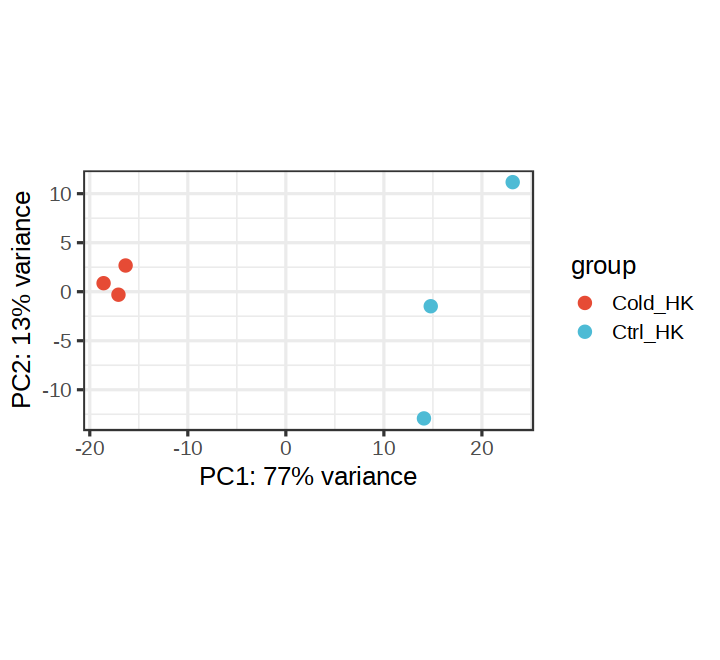

In [117]:
options(repr.plot.width = 6,repr.plot.height = 5.5)
plotPCA(vsd[,grep(colnames(vsd),pattern = "HK")], intgroup='group', ntop=1000) + ggsci::scale_color_npg() + theme_bw(base_size = 15)

In [148]:
pca_function <- function(data){
    mydata<-as.data.frame(t(data))
    mydata=vegan::decostand(mydata,method = "hellinger")
    otu_pca<- prcomp(mydata,scal=F)
    pc12 <- as.data.frame(otu_pca$x[,1:2])*100
    pc12$samples<-rownames(pc12)
    return(pc12)
                             }

In [127]:
library(ggrepel)

In [151]:
pc12 <- pca_function(data = vsd_filtered)
pc12$treat <- gsub("[1-9]","",pc12$samples)
pc12$tissue <- stringr::str_split(pc12$samples,pattern = "_",simplify = T)[,2]

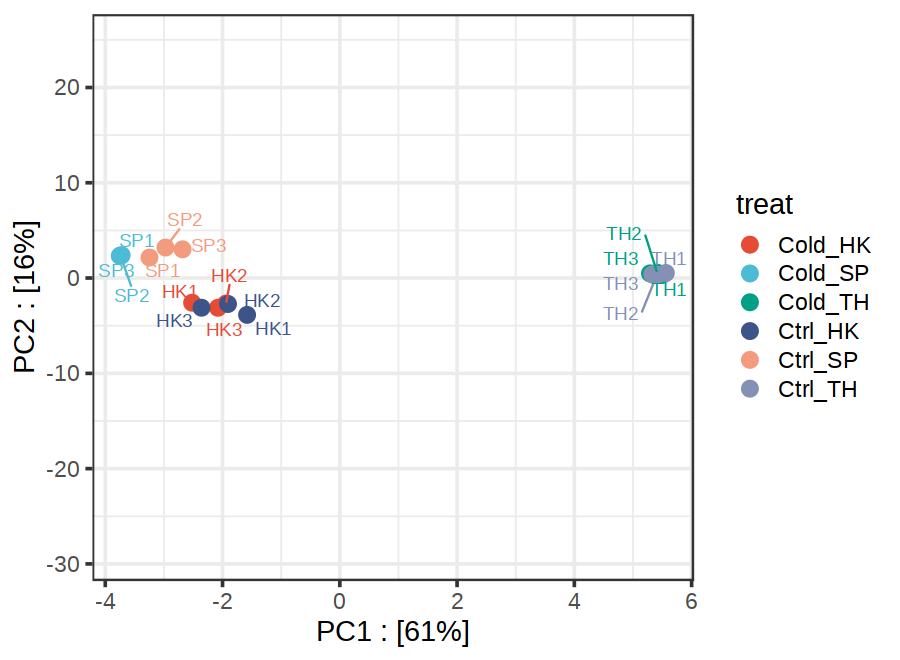

In [152]:
options(repr.plot.width = 7.5,repr.plot.height = 5.5)
ggplot(data = pc12,aes(x = PC1,y = PC2,col = treat)) + 
    geom_point(size = 4) + 
    geom_text_repel(data = pc12,aes(x = PC1,y = PC2,label = tissue),show.legend = F,direction = "both",max.overlaps = 15) +
    ggsci::scale_color_npg() +
    ylim(c(-29,25)) +
    theme_bw(base_size = 17) + labs(x = "PC1 : [61%]", y = "PC2 : [16%]") 

### 1.4.2 ATAC PCA

In [164]:
library(RColorBrewer)
my_palette <- colorRampPalette(brewer.pal(n = 6 , name = "Paired"))(6)

In [165]:
my_palette

[1] "#A6CEE3" "#1F78B4" "#B2DF8A" "#33A02C" "#FB9A99" "#E31A1C"

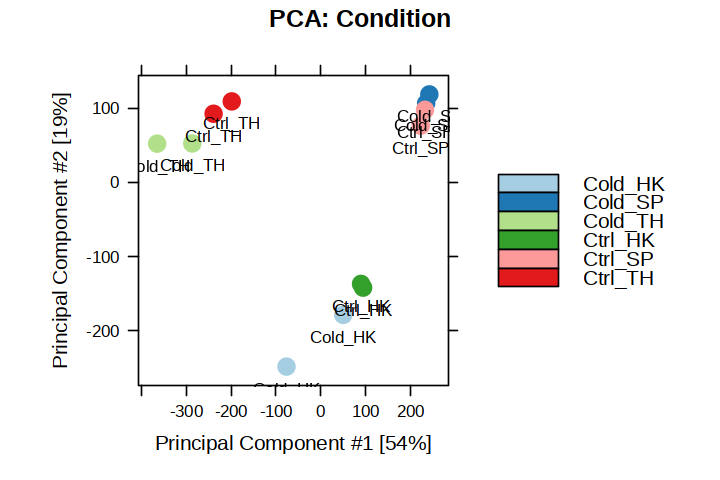

In [334]:
dba.plotPCA(bulk_atac_counts,  attributes=DBA_CONDITION,vColors = my_palette,score = DBA_SCORE_NORMALIZED,label = DBA_CONDITION)

In [970]:
peaks_data <- dba.peakset(bulk_atac_counts, bRetrieve=TRUE, DataType = DBA_FACTOR)
head(peaks_data,3)

,CHR,START,END,Cold_HK1,Cold_HK2,Cold_SP1,Cold_SP2,Cold_TH1,Cold_TH2,Ctrl_HK1,Ctrl_HK2,Ctrl_SP1,Ctrl_SP2,Ctrl_TH1,Ctrl_TH2
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,LG1,22579,22979,5.4690769,6.839567,5.991500,7.767869,5.475077,5.169480,5.6205283,6.283524,7.286811,7.105505,7.430940,3.873598
2,LG1,23301,23701,0.8255210,1.998076,1.815606,1.059255,1.581689,1.292370,0.8483816,1.549362,1.331998,1.579001,1.371866,1.025364
3,LG1,32054,32454,0.6191408,2.612868,1.815606,2.118510,1.216684,1.200058,0.8483816,1.979740,1.802115,2.447452,2.743732,1.595011


In [983]:
mydata <-as.data.frame( t(peaks_data[,c(4:5,8:11,14:15)]) )
mydata = vegan::decostand(mydata,method = "hellinger")
otu_pca <- prcomp(mydata,scal=F)
pc12 <- as.data.frame(otu_pca$x[,1:2])*100
pc12$samples <- rownames(pc12)

In [985]:
pc12$group <- gsub("[1-9]","",pc12$samples)
pc12$treat <- stringr::str_split(pc12$group,pattern = "_",simplify = T)[,1]
pc12$tissue <- stringr::str_split(pc12$group,pattern = "_",simplify = T)[,2]

In [986]:
summary(otu_pca)

Importance of components:
                          PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     0.1853 0.07943 0.04053 0.03537 0.03356 0.03058 0.02908
Proportion of Variance 0.7392 0.13588 0.03538 0.02694 0.02426 0.02014 0.01821
Cumulative Proportion  0.7392 0.87508 0.91046 0.93740 0.96165 0.98179 1.00000
                             PC8
Standard deviation     4.981e-17
Proportion of Variance 0.000e+00
Cumulative Proportion  1.000e+00

In [987]:
pc12$treat <- factor(pc12$treat,levels = c("Ctrl","Cold"))

In [989]:
pdf("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/plot/ATAC_PCA.plot.pdf",width = 4.5,height = 3)
options(repr.plot.width = 6,repr.plot.height = 4)
ggplot(pc12,aes(x = PC1 , y = PC2 ,color = treat,shape = tissue)) + 
    geom_point(size = 4) + scale_color_manual(values = c("#D6AFB9","#7E9BB7")) +
    labs(x = "PC1: 74% variance",y = "PC2: 14% variance" , color = "treat") +
    theme_classic(base_size = 15) + 
    theme(axis.line = element_blank(),panel.border = element_rect(fill=NA,color="black", size=1, linetype="solid"))
dev.off()

png 
  2

## 1.5 Peaks Anno

In [369]:
library(GenomicFeatures)

In [368]:
# callPeaks res from hsq. dir : /home/songqian/Project/Tilapia_Immune/1.ATAC/4.count/macs2
setwd('/home/songqian/Project/Tilapia_Immune/Genome/')
spompe <- GenomicFeatures::makeTxDbFromGFF('Oreochromis_niloticus.O_niloticus_UMD_NMBU.109.gff3',format = "gff3")

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
OK



In [371]:
peakAnnoList <- suppressWarnings(lapply(atac_df$Peaks,ChIPseeker::annotatePeak,
                       TxDb = spompe, 
                       tssRegion = c(-3000, 500), 
                       addFlankGeneInfo = TRUE, 
                       flankDistance = 5000))

>> loading peak file...				 2024-03-06 06:11:53 PM 
>> preparing features information...		 2024-03-06 06:11:53 PM 
>> identifying nearest features...		 2024-03-06 06:11:53 PM 
>> calculating distance from peak to TSS...	 2024-03-06 06:11:54 PM 
>> assigning genomic annotation...		 2024-03-06 06:11:54 PM 
>> adding flank feature information from peaks...	 2024-03-06 06:11:57 PM 
>> assigning chromosome lengths			 2024-03-06 06:12:23 PM 
>> done...					 2024-03-06 06:12:23 PM 
>> loading peak file...				 2024-03-06 06:12:23 PM 
>> preparing features information...		 2024-03-06 06:12:24 PM 
>> identifying nearest features...		 2024-03-06 06:12:24 PM 
>> calculating distance from peak to TSS...	 2024-03-06 06:12:26 PM 
>> assigning genomic annotation...		 2024-03-06 06:12:26 PM 
>> adding flank feature information from peaks...	 2024-03-06 06:12:29 PM 
>> assigning chromosome lengths			 2024-03-06 06:13:14 PM 
>> done...					 2024-03-06 06:13:14 PM 
>> loading peak file...				 2024-03-06 0

In [394]:
names(peakAnnoList) <- atac_df$SampleID

In [406]:
peakAnnoList %>% purrr::map(function(x){
    data <- as.data.frame(x)
    return(data[,c(1:21)])
}) %>% purrr::reduce(dplyr::bind_rows) -> peakAnno_df

In [408]:
peakAnno_df$group <- "Distal"
peakAnno_df$group[grep(peakAnno_df$annotation,pattern = "^Promoter")] <- "Promoter"
peakAnno_df$group[grep(peakAnno_df$annotation,pattern = "^3' UTR|5' UTR")]  <- "Genic"
peakAnno_df$group[grep(peakAnno_df$annotation,pattern = "^Exon|Intron")] <- "Genic"

#peakAnnoList.DEPeaks3 <- peakAnnoList.DEPeaks2 %>% filter(group != "Distal Intergenic")

In [415]:
peakAnno_df$group2 <- gsub("[1-2]_peak_[0-9]*","",peakAnno_df$V4)

In [434]:
head(peakAnno_df,2)

,seqnames,start,end,width,strand,V4,V5,V6,V7,V8,⋯,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS,group,group2
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<int>,<chr>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,LG1,22810,23124,315,*,Cold_HK1_peak_1,95,.,5.42925,11.65361,⋯,608,43174,50651,7478,1,ENSONIG00000015575,ENSONIT00000065129,-20050,Distal,Cold_HK
2,LG1,37517,37742,226,*,Cold_HK1_peak_2,52,.,4.01786,7.21047,⋯,608,43174,50651,7478,1,ENSONIG00000015575,ENSONIT00000065129,-5432,Distal,Cold_HK


In [420]:
pro_df <- table(peakAnno_df$group,peakAnno_df$group2) %>% as.data.frame

In [452]:
pro_df$Var2 <- factor(pro_df$Var2,levels = rev(c("Ctrl_TH","Cold_TH","Ctrl_HK","Cold_HK","Ctrl_SP","Cold_SP")))

In [453]:
pro_df %>% head(2)

,Var1,Var2,Freq
,<fct>,<fct>,<int>
1,Distal,Cold_HK,83872
2,Genic,Cold_HK,130856


In [455]:
pdf(file = "/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/plot/proportion_barplot.pdf",width = 5,height = 4)
ggplot(pro_df,aes(x = Var2 , y = Freq , fill = Var1)) + 
    geom_bar(stat = "identity",orientation = "x",alpha = .9) + 
    scale_fill_manual(values = c("#A5C496", "#C7988C", "#8891DB")) +
    scale_y_continuous(expand = c(0.01,0.01),limits = c(0,450000)) + 
    theme_classic(base_size = 15) + 
    labs(x = NULL , y = NULL , fill = NULL) +
    theme(axis.line = element_blank(),
          axis.text = element_text(colour = "black"),
          legend.position = "top",
          panel.border = element_rect(fill=NA,color="black", size=1, linetype="solid")) + 
    coord_flip()
dev.off()

png 
  2

## 1.6 Visualization of Phenotypic Data

In [170]:
Data_Spleen =data.frame(
    Group = c("Ctrl", "Ctrl", "Ctrl", "Ctrl", "Ctrl", "Ctrl", "Ctrl", "Ctrl", "Ctrl", "Ctrl", "Ctrl", "Ctrl", "Ctrl", "Ctrl", "Ctrl", "Cold", "Cold", "Cold", "Cold", "Cold", "Cold", "Cold", "Cold", "Cold", "Cold", "Cold", "Cold", "Cold", "Cold", "Cold"),
    Weight = c(32.54, 33.57, 28.25, 17.31, 30.02, 25.6, 20.87, 19.94, 20.67, 19.42, 17.72, 21.49, 22.13, 24.31, 20.7, 32.48, 26.92, 24.75, 23.57, 33.28, 21.25, 23.84, 20.05, 22.15, 18.74, 14.24, 16.15, 21.75, 12.85, 15.12),
    Length = c(9.2, 9.2, 8.4, 7.8, 9.1, 8.8, 8.3, 8.4, 8.6, 7.7, 7.3, 8.2, 8.5, 8.5, 8.1, 9.1, 8.9, 9.1, 8.7, 10, 8.5, 8.7, 8.3, 8.6, 8.5, 7.4, 7.6, 8.3, 7.4, 7.6),
    Spleen = c(15.6, 16.8, 18.8, 12, 16.1, 19.3, 12.4, 15.8, 16.2, 17.4, 17.7, 16.8, 15.8, 15.8, 16.4, 38.5, 34.4, 15, 23.1, 42.5, 25.8, 18.1, 15.5, 16.4, 17.2, 11.5, 12.2, 26, 9.1, 15.2),
    Index = c(0.479, 0.500, 0.665, 0.693, 0.536, 0.754, 0.594, 0.792, 0.784, 0.896, 0.999, 0.782, 0.714, 0.650, 0.792, 1.185, 1.278, 0.606, 0.980, 1.277, 1.214, 0.759, 0.773, 0.740, 0.918, 0.808, 0.755, 1.195, 0.708, 1.005)
)

In [202]:
Data_Spleen$Group <- factor(Data_Spleen$Group,levels = c("Ctrl","Cold"))

In [244]:
Data_Spleen %>% head(2)

,Group,Weight,Length,Spleen,Index
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,Ctrl,32.54,9.2,15.6,0.479
2,Ctrl,33.57,9.2,16.8,0.500


In [207]:
library(patchwork)

In [218]:
options(repr.plot.width = 3,repr.plot.height = 4)
p1 <- ggplot(Data_Spleen,aes(x = Group,y = Index,fill = Group)) + 
    geom_violin(trim=FALSE,color="black") + 
    geom_jitter(width = .1) +
    geom_boxplot(width = .1,fill = "white",outlier.shape = NA) +
    scale_fill_manual(values = c("#D6AFB9","#7E9BB7")) + 
    ylab("Spleen index") +
    xlab(NULL) +
    theme_classic(base_size = 19) + 
    theme(legend.position = "none")
p2 <- ggplot(Data_Spleen,aes(x = Group,y = Length,fill = Group)) + 
    geom_violin(trim=FALSE,color="black") + 
    geom_jitter(width = .1) +
    geom_boxplot(width = .1,fill = "white",outlier.shape = NA) +
    scale_fill_manual(values = c("#D6AFB9","#7E9BB7")) + 
    ylab("Body length(cm)") +
    xlab(NULL) +
    theme_classic(base_size = 19) + 
    theme(legend.position = "none")

p3 <- ggplot(Data_Spleen,aes(x = Group,y = Weight,fill = Group)) + 
    geom_violin(trim=FALSE,color="black") + 
    geom_jitter(width = .1) +
    geom_boxplot(width = .1,fill = "white",outlier.shape = NA) +
    scale_fill_manual(values = c("#D6AFB9","#7E9BB7")) + 
    ylab("Body weight(g)") +
    xlab(NULL) +
    theme_classic(base_size = 19) + 
    theme(legend.position = "none")

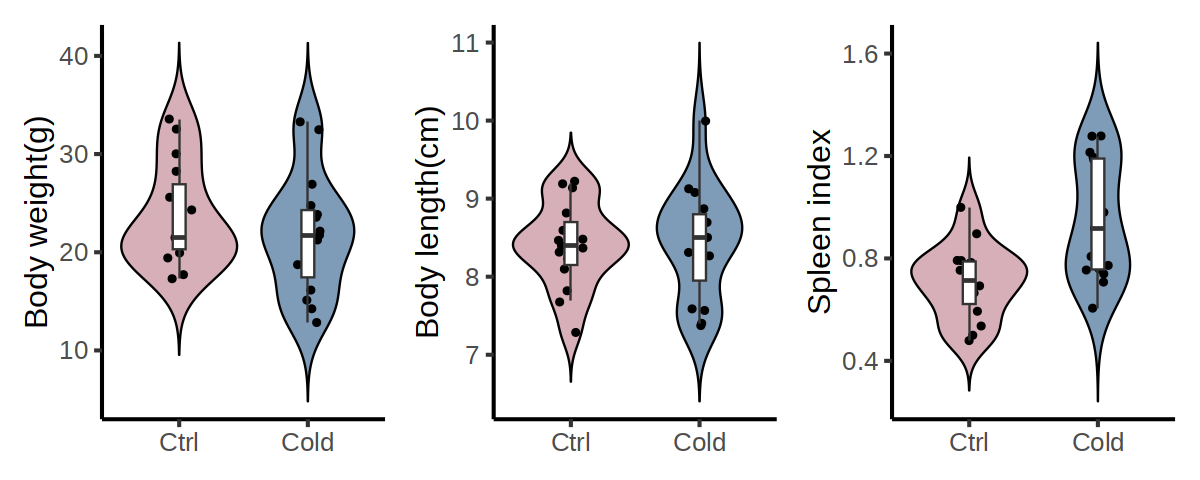

In [219]:
options(repr.plot.width = 10,repr.plot.height = 4)
p3 | p2 | p1

In [220]:
pdf(file = "/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/表型数据_plot/Vlnplot.pdf",width = 10,height = 4)
p3 | p2 | p1
dev.off()

png 
  2

In [245]:
Data_Breathe =data.frame(
    Temp = c(28.0, 27.0, 26.0, 21.0, 17.5, 16.2, 16.2, 15.0, 12.5, 12.0, 12.5, 27.6, 27.7, 27.8, 25.5, 25.0, 24.8, 24.4, 23.0, 22.0, 21.9, 20.1, 20.1, 18.3, 18.2, 16.4, 16.3, 15.7, 15.1, 15.1, 13.9, 13.6, 13.4, 12.5, 19.5, 23.5, 23.2, 24.2, 24.5, 20.2, 19.7, 19.1, 18.8, 18.8, 18.1, 17.5, 17.0, 16.0, 15.2, 14.0, 13.5, 12.5, 27.7, 27.6, 27.0),
    Freq = c(125.71, 108.00, 109.50, 93.00, 89.00, 61.50, 80.00, 79.50, 62.00, 60.00, 66.00, 134.00, 132.00, 130.50, 115.20, 109.76, 111.00, 114.86, 121.94, 110.32, 110.32, 100.00, 102.00, 94.00, 106.45, 98.00, 100.00, 90.00, 86.25, 89.03, 92.00, 90.00, 87.10, 90.00, 118.00, 127.74, 112.00, 114.19, 128.57, 102.00, 109.20, 72.00, 104.00, 96.00, 93.00, 96.00, 94.00, 84.00, 98.18, 94.00, 86.00, 76.00, 124.00, 120.00, 124.00) 
)

In [467]:
p4 <- ggplot(Data_Breathe,aes(x = Temp,y = Freq)) + 
    geom_point() + 
    scale_x_reverse() +
    geom_smooth(method = "loess" ,size = 1,se = T) +
#     scale_x_continuous(limits = c(max(Data_Breathe$Temp), min(Data_Breathe$Temp)), 
#                        breaks = seq(max(Data_Breathe$Temp), min(Data_Breathe$Temp), by = -1) ) + 
    labs(x = "Water temperture (°C)" , y = "Breathing frequency (min-1)") + 
    theme_classic(base_size = 19)

In [456]:
Data_swim =data.frame(
Speed=c(18.22, 14.56, 14.47, 12.20, 10.62, 10.29, 10.04, 9.91, 9.69, 8.64, 7.76, 7.44, 18.24, 17.71, 16.89, 13.87, 13.22, 13.18, 11.02, 7.71, 7.29, 5.73, 5.33, 19.96, 18.44, 16.84, 15.33, 14.78, 14.71, 14.47, 8.16, 4.22, 4.04, 3.73, 18.33, 14.22, 14.18, 11.31, 9.22, 6.13, 5.36, 4.11, 3.87, 2.98, 13.38, 12.82, 11.38, 10.20, 6.84, 6.47, 5.82, 3.69, 3.47, 3.27, 3.20, 2.71, 2.71, 2.67, 14.20, 12.33, 7.31, 5.29, 3.40, 2.62, 14.64, 11.58, 9.00, 7.47, 7.20, 6.89, 6.58, 5.98, 4.33, 4.31, 3.13, 3.09, 3.02, 2.93, 2.91, 2.80, 1.91, 10.13, 9.87, 8.96, 6.64, 5.47, 5.40, 4.69, 3.76, 2.84, 2.22, 11.20, 10.76, 7.60, 7.58, 6.93, 6.87, 6.33, 5.80, 4.58, 2.58, 2.27, 12.60, 9.91, 9.51, 9.29, 5.91, 5.40, 3.60, 3.42, 2.93, 2.69, 2.62, 2.31, 2.27, 9.96, 9.91, 9.16, 8.91, 7.07, 6.69, 6.13, 5.16, 3.93, 3.24, 2.80, 2.53, 2.00, 1.73, 10.09, 8.09, 7.09, 4.96, 4.58, 4.00, 3.73, 3.02, 2.47, 2.22, 2.22, 10.51, 8.53, 5.33, 3.62, 2.89, 8.69, 8.58, 7.29, 7.11, 6.87, 6.84, 6.24, 5.76, 5.44, 5.36, 4.60, 3.24, 2.89, 2.69, 2.51, 2.24, 8.38, 6.47, 6.33, 6.00, 4.18, 4.09, 3.24, 3.09, 2.73, 2.64, 2.64, 2.38, 1.98, 1.84, 9.64, 8.89, 8.71, 8.00, 7.53, 6.91, 5.16, 4.73, 4.00, 3.82, 3.82, 3.13, 2.42, 2.38, 2.31, 1.96, 1.73, 8.69, 7.87, 6.60, 6.56, 6.16, 6.02, 5.69, 5.27, 5.13, 5.07, 4.80, 3.89, 3.73, 3.67, 3.49, 2.80, 2.53, 1.93, 1.58, 1.51), 
Temperature=c(27.31, 28.17, 27.62, 28.07, 27.34, 27.88, 27.75, 27.33, 27.52, 28.26, 28.09, 28.25, 26.88, 26.85, 26.79, 27.54, 26.65, 26.89, 27.04, 26.64, 27.00, 27.34, 27.51, 26.80, 26.64, 26.71, 26.40, 26.08, 26.06, 26.21, 26.53, 26.26, 26.11, 26.29, 25.32, 25.25, 25.73, 25.47, 25.62, 25.63, 25.64, 25.94, 25.93, 25.49, 23.97, 24.35, 24.06, 23.74, 23.62, 23.74, 23.71, 24.53, 24.39, 24.08, 24.35, 24.13, 23.97, 24.48, 23.80, 23.13, 23.59, 23.43, 23.87, 23.21, 22.90, 23.09, 22.63, 23.04, 23.45, 22.65, 22.68, 22.90, 22.87, 22.59, 23.20, 23.40, 22.62, 22.89, 23.04, 22.78, 22.65, 22.04, 21.73, 21.74, 21.90, 21.52, 21.63, 22.03, 21.86, 22.04, 22.18, 21.18, 20.72, 21.19, 20.96, 20.74, 20.63, 21.32, 21.29, 21.22, 21.03, 20.65, 20.50, 19.72, 20.23, 19.55, 19.57, 19.87, 19.87, 20.39, 20.40, 20.01, 20.02, 20.14, 20.43, 19.00, 18.92, 18.51, 19.11, 19.01, 18.74, 19.00, 18.42, 18.74, 18.78, 18.39, 18.34, 18.97, 18.71, 17.74, 17.81, 17.65, 17.61, 17.60, 17.55, 17.79, 17.94, 17.58, 18.45, 18.03, 16.95, 17.33, 16.99, 16.95, 17.18, 17.02, 16.30, 16.56, 16.43, 17.00, 16.44, 16.40, 16.49, 16.59, 16.75, 16.21, 16.83, 16.27, 16.96, 16.63, 17.15, 15.76, 16.23, 16.26, 15.93, 15.84, 15.86, 16.44, 15.56, 15.61, 15.66, 15.98, 16.27, 16.02, 16.12, 16.00, 15.81, 15.39, 15.43, 15.63, 15.43, 15.74, 15.14, 15.47, 15.18, 15.49, 15.59, 15.57, 15.75, 15.89, 16.10, 15.90, 13.81, 13.75, 13.62, 13.69, 13.41, 13.78, 14.24, 13.94, 13.50, 13.92, 13.65, 14.09, 13.70, 14.33, 13.78, 14.39, 14.27, 14.06, 13.42, 14.20)
)

In [458]:
Data_swim %>% head(2)

,Speed,Temperature
,<dbl>,<dbl>
1,18.22,27.31
2,14.56,28.17


In [465]:
p5 <- ggplot(Data_swim,aes(x = Temperature,y = Speed)) + 
    geom_point() + 
    scale_x_reverse(breaks = c(25,20,15)) +
    geom_smooth(method = "loess" ,size = 1,se = T) +
#     scale_x_continuous(limits = c(max(Data_Breathe$Temp), min(Data_Breathe$Temp)), 
#                        breaks = seq(max(Data_Breathe$Temp), min(Data_Breathe$Temp), by = -1) ) + 
    xlab("Water temperture (°C)") +  ylab("swimming speed (cm.min-1)") +
    theme_classic(base_size = 19)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


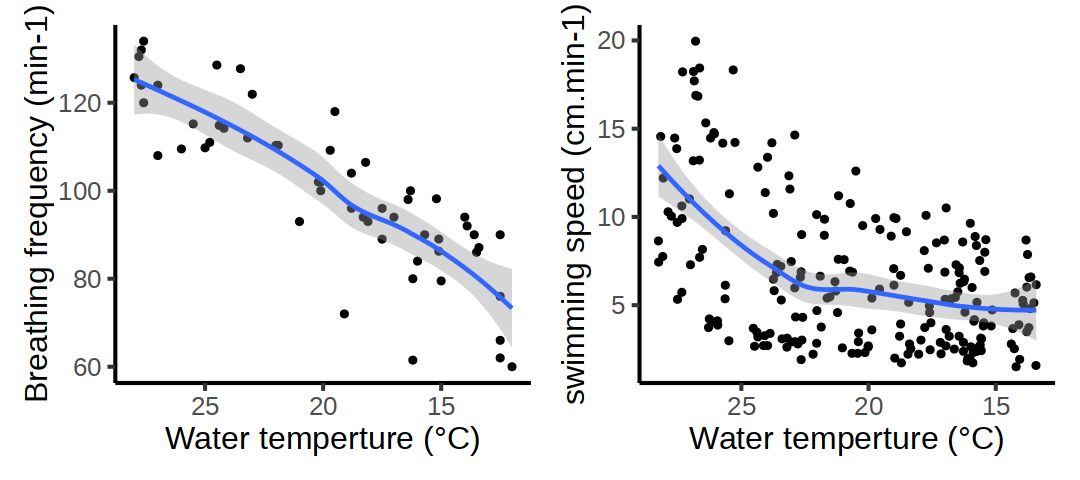

In [469]:
options(repr.plot.width = 9,repr.plot.height = 4)
p4 + p5

In [470]:
pdf(file = "/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/表型数据_plot/Phenotype_Curve.pdf",width = 9,height = 4)
p4 + p5
dev.off()

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


png 
  2

In [543]:
temp <- data.frame(x = c('ct1','ct2','ct3','cd1','cd2','cd3'),
          y = c(26.24671916,30.83989501,20.34120735,38.05774278,26.24671916,41.33858268),
                  group = c("Ctrl","Ctrl","Ctrl","Cold","Cold","Cold"))
temp$group <- factor(temp$group,levels = c("Ctrl","Cold"))

In [544]:
head(temp,2)

,x,y,group
,<chr>,<dbl>,<fct>
1,ct1,26.24672,Ctrl
2,ct2,30.83990,Ctrl


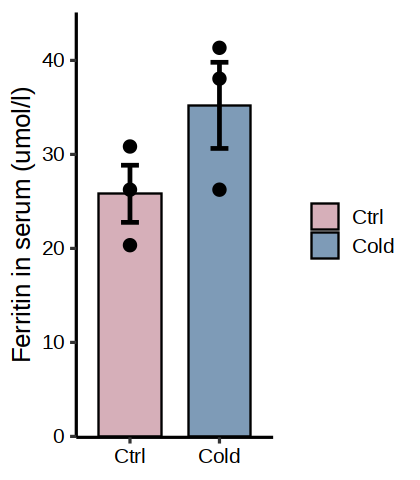

In [570]:
options(repr.plot.width = 3.5,repr.plot.height = 4)
Ferritin_plot <- ggplot(temp,aes(group,y,color=group,fill=group))+
  geom_bar(stat="summary",fun=mean,width = 0.7, color = "black",position = )+
  geom_point(color = "black",fill="black",size = 3,alpha=1,shape = 21)+ #position = 'jitter'
  geom_errorbar(stat = "summary", fun.data = mean_se, width = 0.2, color = "black",size = 1)+
  scale_x_discrete(limits = c("Ctrl","Cold")) +
  scale_y_continuous(expand = c(0.0,0.1),limits = c(0,45)) +
  scale_fill_manual(values = c("#D6AFB9","#7E9BB7")) +
  theme_classic(base_size = 15) + 
  labs(x = NULL , y = "Ferritin in serum (umol/l)",color = NULL,fill = NULL) + 
  theme(axis.text = element_text(color = "black"))
Ferritin_plot

In [618]:
t.test(y ~ group, data = temp)


	Welch Two Sample t-test

data:  y by group
t = -1.7104, df = 3.4737, p-value = 0.1731
alternative hypothesis: true difference in means between group Ctrl and group Cold is not equal to 0
95 percent confidence interval:
 -25.628578   6.818429
sample estimates:
mean in group Ctrl mean in group Cold 
          25.80927           35.21435 


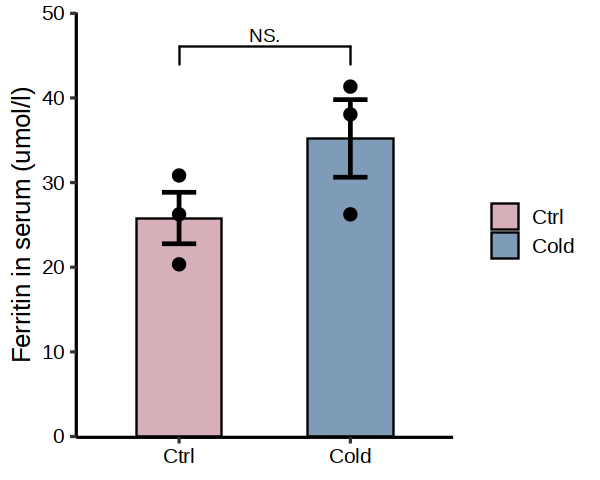

In [564]:
ggplot(temp, aes(x = group, y = y, fill = group)) +
  geom_bar(stat = "summary", fun = mean, width = 0.5, color = "black") +
  geom_point(color = "black", fill = "black", size = 3, alpha = 1, shape = 21) +
  geom_errorbar(stat = "summary", fun.data = mean_se, width = 0.2, color = "black", size = 1) +
  scale_x_discrete(limits = c("Ctrl", "Cold")) +
  scale_y_continuous(expand = c(0.0, 0.1), limits = c(0, 50)) +
  scale_fill_manual(values = c("#D6AFB9", "#7E9BB7")) +
  theme_classic(base_size = 15) +
  labs(x = NULL, y = "Ferritin in serum (umol/l)", color = NULL, fill = NULL) +
  theme(axis.text = element_text(color = "black")) +
  ggsignif::geom_signif(comparisons = list(c("Ctrl", "Cold")), test = "t.test",
                        map_signif_level = TRUE,y_position = 45, tip_length = 0.1)

In [571]:
pdf(file = "/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/表型数据_plot/Ferritin_barplot.pdf",width = 3.5,height = 4)
Ferritin_plot
dev.off()

png 
  2

In [603]:
CAT <- data.frame(Temperature = c("Ctrl","Ctrl","Ctrl","Cold", "Cold","Cold","Ctrl","Ctrl","Ctrl","Cold","Cold","Cold"),
        Tissue = c("TH", "TH","TH", "TH","TH", "TH", "HK", "HK", "HK", "HK", "HK", "HK"),
        value = c(3.560011,3.30467,2.93045,3.904561,4.437935,3.2272,
                    2.044445,3.55007 ,3.07890 ,3.43511,4.722056,4.56700)
                 )

In [604]:
CAT$Temperature <- factor(CAT$Temperature,levels = c("Ctrl","Cold"))
CAT$Tissue <- factor(CAT$Tissue,levels = c("TH","HK"))

In [621]:
t.test(value ~ Temperature, data = CAT[1:6,])#TH
t.test(value ~ Temperature, data = CAT[7:12,])#HK


	Welch Two Sample t-test

data:  value by Temperature
t = -1.4969, df = 3.0141, p-value = 0.2309
alternative hypothesis: true difference in means between group Ctrl and group Cold is not equal to 0
95 percent confidence interval:
 -1.845797  0.662754
sample estimates:
mean in group Ctrl mean in group Cold 
          3.265044           3.856565 



	Welch Two Sample t-test

data:  value by Temperature
t = -2.2434, df = 3.9667, p-value = 0.08885
alternative hypothesis: true difference in means between group Ctrl and group Cold is not equal to 0
95 percent confidence interval:
 -3.0268585  0.3263578
sample estimates:
mean in group Ctrl mean in group Cold 
          2.891138           4.241389 


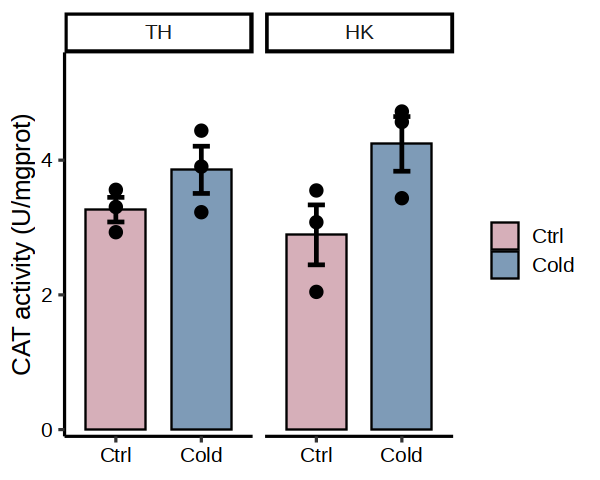

In [605]:
options(repr.plot.width = 5,repr.plot.height = 4)
CAT_plot <- ggplot(CAT,aes(Temperature,value,color=Temperature,fill=Temperature))+
  geom_bar(stat="summary",fun=mean,width = 0.7, color = "black")+
  geom_point(color = "black",fill="black",size = 3,alpha=1,shape = 21)+ #position = 'jitter'
  facet_grid(~Tissue,scales = "free") +
  geom_errorbar(stat = "summary", fun.data = mean_se, width = 0.2, color = "black",size = 1)+
  #scale_x_discrete(limits = c("Ctrl","Cold")) +
  scale_y_continuous(expand = c(0.0,0.1),limits = c(0,5.5)) +
  scale_fill_manual(values = c("#D6AFB9","#7E9BB7")) +
  theme_classic(base_size = 15) + 
  labs(x = NULL , y = "CAT activity (U/mgprot)",color = NULL,fill = NULL) + 
  theme(axis.text = element_text(color = "black"))
CAT_plot

In [608]:
pdf(file = "/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/表型数据_plot/CAT_barplot.pdf",width = 5,height = 4)
CAT_plot
dev.off()

png 
  2

In [609]:
MDA <- data.frame(Temperature = c("Ctrl","Ctrl","Cold","Cold","Ctrl","Ctrl","Cold","Cold"),
        Tissue = c("TH", "TH","TH","TH","HK","HK","HK","HK"),
        value = c(1.049033,0.998789,1.865498,1.50989,
                    3.099917,4.74740,6.482635,4.912801))

In [610]:
MDA$Temperature <- factor(MDA$Temperature,levels = c("Ctrl","Cold"))
MDA$Tissue <- factor(MDA$Tissue,levels = c("TH","HK"))

In [624]:
t.test(value ~ Temperature, data = MDA[1:4,])#TH
t.test(value ~ Temperature, data = MDA[5:8,])#HK


	Welch Two Sample t-test

data:  value by Temperature
t = -3.6965, df = 1.0399, p-value = 0.1606
alternative hypothesis: true difference in means between group Ctrl and group Cold is not equal to 0
95 percent confidence interval:
 -2.748564  1.420998
sample estimates:
mean in group Ctrl mean in group Cold 
          1.023911           1.687694 



	Welch Two Sample t-test

data:  value by Temperature
t = -1.5592, df = 1.9954, p-value = 0.2596
alternative hypothesis: true difference in means between group Ctrl and group Cold is not equal to 0
95 percent confidence interval:
 -6.680658  3.132539
sample estimates:
mean in group Ctrl mean in group Cold 
          3.923659           5.697718 


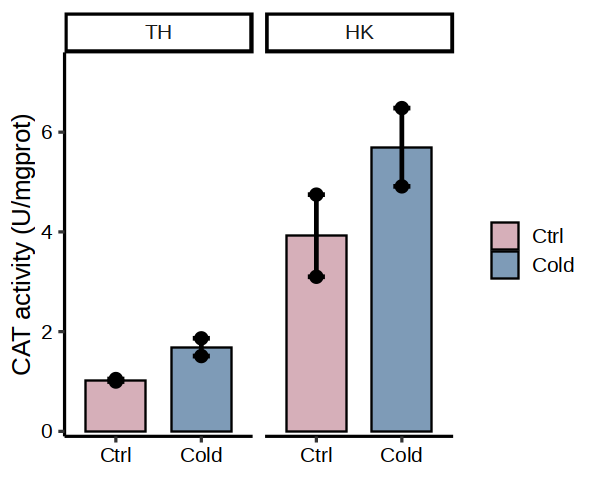

In [616]:
options(repr.plot.width = 5,repr.plot.height = 4)
MDA_plot <- ggplot(MDA,aes(Temperature,value,color=Temperature,fill=Temperature))+
  geom_bar(stat="summary",fun=mean,width = 0.7, color = "black")+
  geom_point(color = "black",fill="black",size = 3,alpha=1,shape = 21)+ #position = 'jitter'
  facet_grid(~Tissue,scales = "free") +
  geom_errorbar(stat = "summary", fun.data = mean_se, width = 0.2, color = "black",size = 1)+
  #scale_x_discrete(limits = c("Ctrl","Cold")) +
  scale_y_continuous(expand = c(0.0,0.1),limits = c(0,7.5)) +
  scale_fill_manual(values = c("#D6AFB9","#7E9BB7")) +
  theme_classic(base_size = 15) + 
  labs(x = NULL , y = "CAT activity (U/mgprot)",color = NULL,fill = NULL) + 
  theme(axis.text = element_text(color = "black"))
MDA_plot

In [617]:
pdf(file = "/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/表型数据_plot/MDA_barplot.pdf",width = 5,height = 4)
MDA_plot
dev.off()

png 
  2

## 1.7 Heatmap

In [ ]:
library(ComplexHeatmap)

In [ ]:
DEGs <- DEG.RNA_2 %>% filter(tissue != "SP") %>% .$gene %>% unique

In [ ]:
BulkRNA_df2 <- BulkRNA_df[,grep(names(BulkRNA_df),pattern = "SP",invert = T)] %>% dplyr::select(7:9,1:3,10:12,4:6)

In [ ]:
scale_row <- function(x){
    m = apply(x, 1, mean, na.rm = T)
    s = apply(x, 1, sd, na.rm = T)
    return((x - m) / s)
}

In [ ]:
BulkRNA_df.scale <- BulkRNA_df2[DEGs,] %>% na.omit
BulkRNA_df.scale[,1:6] <- scale_row(BulkRNA_df.scale[,1:6])
BulkRNA_df.scale[,7:12] <- scale_row(BulkRNA_df.scale[,7:12])

In [ ]:
BulkRNA_df.scale2 <- BulkRNA_df.scale[complete.cases(BulkRNA_df.scale), ]

In [ ]:
mat <- vst(dds, blind=FALSE) %>% assay
mat2 <- mat[,grep(names(mat),pattern = "SP",invert = T)]
mat2 <- mat2[,c(7:9,1:3,10:12,4:6)]

In [ ]:
mat2.scale <- mat2[DEGs,]
mat2.scale[,1:6] <- scale_row(mat2.scale[,1:6])
mat2.scale[,7:12] <- scale_row(mat2.scale[,7:12])

In [ ]:
mat2.scale2 <- mat2.scale[complete.cases(mat2.scale), ]

In [ ]:
vst.heatmap <- Heatmap(mat2.scale2,
        col = colorRampPalette(c("navy","white","firebrick3"))(100),
        clustering_distance_rows = function(m) dist(m),
        clustering_method_rows = "ward.D2",
        row_km = 3,
        use_raster = TRUE,
        border = TRUE,
        column_split = factor( rep(c("HK","TH"), each = 6)),
        heatmap_legend_param = list(
             title='Z score',
             title_gp = gpar(fontsize = 14),
             labels_gp = gpar(fontsize = 14),
             border='black'),
        show_row_names = FALSE)
vst.heatmap2 <- draw(vst.heatmap)

In [ ]:
cluster_gene <- do.call(rbind, lapply(names( row_order(vst.heatmap2) ) , function(name) {
      data.frame(cluster = name, gene = rownames(mat2.scale2)[ row_order(vst.heatmap2)[[name]] ], stringsAsFactors = FALSE)
}))

In [ ]:
saveRDS(mat2.scale2[cluster_gene$gene,],
      "/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/Bulk_RNA_output/20240308_ZMH_Fig1_Heatmap_matrix.rds")

In [ ]:
#table(cluster_gene$gene) 获取row_cluster相关信息
row_cluster <- c( rep("cluster3",times = 932),
  rep("cluster2",times = 3317),
  rep("cluster1",times = 3611))
row_cluster <- factor(row_cluster,levels = c("cluster1","cluster2","cluster3"))

In [ ]:
temp <- mat2.scale2[cluster_gene$gene,]

In [ ]:
vst.heatmapc <- Heatmap(temp,cluster_row_slices = FALSE,
        col = colorRampPalette(c("#1C86EE","white","#FF4500"))(100),
        cluster_columns = F,              
        clustering_distance_rows = function(m) dist(m),
        clustering_method_rows = "ward.D2",
        #row_km = 5,
        use_raster = TRUE,
        border = TRUE,
        row_split = row_cluster,
        column_split = factor( rep(c("HK","TH"), each = 6)),
        heatmap_legend_param = list(
             title='Z score',
             title_gp = gpar(fontsize = 14),
             labels_gp = gpar(fontsize = 14),
             border='black'),
        show_row_names = FALSE,
                        width = unit(10, "cm"),
        height = unit(16, "cm"),
         show_column_dend = FALSE,
        column_names_rot = 45)
vst.heatmap2c <- draw(vst.heatmapc)


In [ ]:
pdf("heatmap6.pdf", width = 5, height = 13)
vst.heatmap2c
dev.off()

In [ ]:
cluster_gene2 <- cluster_gene %>% group_by(gene) %>% left_join(geneID_name,by = "gene") %>% distinct()

In [ ]:
saveRDS(vst.heatmap2,"/home/minghao/workbase_jinagbo/RNA_vst_heatmap.rds")

In [ ]:
openxlsx::write.xlsx(cluster_gene2,
                     "/home/minghao/workbase_jinagbo/Heatmap_clustergenes.xlsx")

## 1.8 barplot

In [3]:
TPM <- read.table("/home/songqian/Project/Tilapia_Immune/0.RNA/4.count/Tilapia_tpm.xls",header=TRUE,row.names=1,sep="\t",check.names = F)

In [27]:
library(ggplot2)

In [47]:
barplot <- function(gene,gene_name = "gene_name"){
    require("ggplot2")
    require("dplyr")
    plot <- TPM %>% tibble::rownames_to_column(var = "gene") %>% reshape2::melt() %>% dplyr::rename("tissue" = variable) %>% 
                mutate(group = gsub("[1-9]$","",tissue)) %>% filter(gene == "ENSONIG00000038739") %>% 
                ggplot(aes(x = group,y = value,color = group,fill = group)) + 
                    geom_point(color = "black",fill="black",size = 1,alpha=1,shape = 21)+ 
                    geom_bar(stat = "summary",fun=mean) +
                    geom_errorbar(stat = "summary", fun.data = mean_se, width = 0.3, color = "black",size = 1.5)+
                    theme_classic(base_size = 15,
                                  base_line_size = 0.8)+
                    #facet_grid(~tissue,scales = 'free')+
                    scale_fill_manual(values = c("#D6AFB9", "#7E9BB7","#D6AFB9", "#7E9BB7","#D6AFB9", "#7E9BB7"))+
                    scale_color_manual(values = c("#D6AFB9", "#7E9BB7","#D6AFB9", "#7E9BB7","#D6AFB9", "#7E9BB7"))+
                    ggtitle(gene_name) + xlab("") + ylab("") +
                    theme(legend.position = "none",plot.title = element_text(hjust = .5,face = "italic"),
                          axis.text.y = element_text(colour = "black"),
                          axis.text.x = element_text(angle = 45,hjust = 1,vjust = 1,colour = "black"))+
                    theme(panel.spacing = unit(1, "cm"))
    return(plot)
}

Using gene as id variables



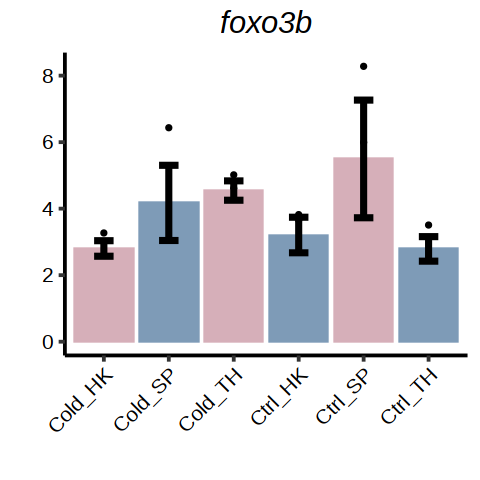

In [48]:
options(repr.plot.width = 4, repr.plot.height = 4)
barplot(gene = "ENSONIG00000013292",gene_name = "foxo3b")

## 1.9 TF enrichment

In [ ]:
#From biomart
TF_fam <- read.table("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/TF_family/Oreochromis_niloticus_TF.txt",
                     sep = "\t",header = TRUE)

In [ ]:
TF_fam_2 <- TF_fam[,c(3,4)] %>% distinct() %>% arrange(Family) %>% dplyr::select(term = Family,gene = Ensembl)

In [ ]:
library(clusterProfiler)

In [ ]:
lapply(split(cluster_gene$gene,f = cluster_gene$cluster) ,function(genes){
    genes2 <- genes[genes %in% TF_fam_2$gene]#挑选是TF的DEGs
    print(c("TF Num :",length(genes2)))
    res <- enricher(gene = genes2,TERM2GENE = TF_fam_2,pAdjustMethod = "BH",minGSSize = 3)
    return(res)
}) -> TF_enrich_res

names(TF_enrich_res) <- paste("cluster",names(split(cluster_gene$gene,f = cluster_gene$cluster)),sep = "")

In [ ]:
lapply(names(TF_enrich_res),function(x){
    x2 <- TF_enrich_res[[x]]@result
    x2$cluster <- x
    return(x2)
}) -> TF_enrich_res_list
TF_enrich_res_df <- do.call(rbind,TF_enrich_res_list)

In [ ]:
openxlsx::write.xlsx(TF_enrich_res_df,
                     "BulkRNA_TF_enrichment.xlsx")

In [ ]:
TF_enrich_res_df_filter <- TF_enrich_res_df %>% 
    filter(p.adjust < 0.05) %>% group_by(cluster) %>% 
    arrange(p.adjust,.by_group = TRUE) %>% ungroup

In [ ]:
openxlsx::write.xlsx(TF_enrich_res_df_filter,
                     "BulkRNA_TF_enrichment_filter.xlsx")

## 1.10 GO enrichment

In [ ]:
#GO_KEGG富集分析相关函数
enrichment_stat_go = function(bl,il) {
#  gos <- gene_go2
#  go_des <- go_des
  gos.bl <- gos[gos$gene %in% bl,]
  gos.il <- gos[gos$gene %in% il,]
  gos.bl.stat <- gos.bl %>% group_by(GO) %>% dplyr::summarise(GeneNumber=n()) %>% ungroup
  gos.il.stat <- gos.il %>% group_by(GO) %>% dplyr::summarise(GeneNumber=n()) %>% ungroup
  list.df <- gos.bl.stat %>% group_by(GO) %>% left_join(gos.il.stat,by="GO") %>% ungroup
  list.df[is.na(list.df)] <- 0
  names(list.df) <- c("GO","k","x")#k:bl x:il
  list.df$m = as.numeric(length(unique(sort(gos.il$gene))))
  list.df$n = as.numeric(length(unique(sort(gos.bl$gene))))-list.df$k
  list.df$Pvalue <- apply(list.df[,-1],1,FUN=function(x) {phyper(x[2]-1,x[1],x[4],x[3],lower.tail=F)})
  # if (id == "go"){
  #   list <- list[list$class == "biological_process" & list$k >= 10,]
  # }
  
  #list$p.adjust <- p.adjust(list$Pvalue,method="fdr",n=length(list$Pvalue))
  list.df <- list.df[order(list.df$Pvalue,decreasing=F),]
  list.df$fold = list.df$x*(list.df$n+list.df$k)/list.df$m/list.df$k ## should add fold enrichment value
  list.1 <- list.df %>% group_by(GO) %>% left_join(go_des,by="GO") %>% ungroup
  list.1 <- list.1[list.1$k>=10 & list.1$x>=3,]
  list.1$p.adjust <- p.adjust(list.1$Pvalue,method="fdr",n=length(list.1$Pvalue))
  list.1 <- list.1[list.1$Pvalue < 0.05,]
  list.1
}

enrichment_stat_kegg = function(bl,il) {
#  keggs <- keggs
#  kegg_des <- kegg_des
  
  keggs.bl <- keggs[keggs$gene %in% bl,]
  keggs.il <- keggs[keggs$gene %in% il,]
  keggs.bl.stat <- keggs.bl %>% group_by(kegg) %>% dplyr::summarise(GeneNumber=n()) %>% ungroup
  keggs.il.stat <- keggs.il %>% group_by(kegg) %>% dplyr::summarise(GeneNumber=n()) %>% ungroup
  list.df <- keggs.bl.stat %>% group_by(kegg) %>% left_join(keggs.il.stat,by="kegg") %>% ungroup
  list.df[is.na(list.df)]<-0
  names(list.df) <- c("kegg","k","x")
  list.df$m = as.numeric(length(unique(sort(keggs.il$gene))))
  list.df$n = as.numeric(length(unique(sort(keggs.bl$gene))))-list.df$k
  list.df$Pvalue <- apply(list.df[,-1],1,FUN=function(x) {phyper(x[2]-1,x[1],x[4],x[3],lower.tail=F)})
  # if (id == "kegg"){
  #   list <- list[list$class == "biological_process" & list$k >= 10,]
  # }
  
  #list.df$p.adjust <- p.adjust(list.df$Pvalue,method="fdr",n=length(list.df$Pvalue))
  list.df <- list.df[order(list.df$Pvalue,decreasing=F),]
  list.df$fold = list.df$x*(list.df$n+list.df$k)/list.df$m/list.df$k ## should add fold enrichment value
  list.1 <- list.df %>% group_by(kegg) %>% left_join(kegg_des,by="kegg") %>% ungroup
  list.1 <- list.1[list.1$k>=10 & list.1$x>=2,]
  list.1$p.adjust <- p.adjust(list.1$Pvalue,method="fdr",n=length(list.1$Pvalue))
  list.1 <- list.1[list.1$Pvalue < 0.05,]
  list.1
}

In [ ]:
load("/home/minghao/database/KEGG_KO_database/02_niletilapia/01_enrichment_gos_keggs/go_info.RData")
load("/home/minghao/database/KEGG_KO_database/02_niletilapia/01_enrichment_gos_keggs/kegg_info.RData")

In [ ]:
lapply(split(cluster_gene$gene,f = cluster_gene$cluster),function(x){
    GO_res <- enrichment_stat_go(bl = rownames(mat2),il = x)
    return(GO_res)
}) -> GO_res

In [ ]:
names(GO_res) <- paste("cluster",names(split(cluster_gene$gene,f = cluster_gene$cluster)),sep = "")

In [ ]:
openxlsx::write.xlsx(GO_res,
                     "/home/minghao/workbase_jinagbo/Heatmap_cluster_gene_GO.xlsx")

In [ ]:
head(geneID_name)
geneID_name_uniq <- geneID_name %>% group_by(gene) %>% dplyr::slice(1) %>% ungroup
head(geneID_name_uniq)

In [ ]:
library(dplyr)
lapply(split(cluster_gene$gene,f = cluster_gene$cluster),function(x){
    GO_res <- enrichment_stat_go(bl = rownames(mat2),il = x)
    
    gos2 <- gos %>% group_by(gene)  %>% left_join(geneID_name_uniq,by = "gene") %>% ungroup
    
    GO_gene <- gos2[gos2$gene %in% x,] %>% group_by(GO) %>% summarise(gene = paste(gene,collapse = "/"),
                                                                      Gene.name = paste(Gene.name,collapse = "/"),
                                                                      eggnog_Preferred_name = paste(eggnog_Preferred_name,collapse = "/")
                                                                     ) %>% ungroup
    
    GO_res2 <- GO_res %>% left_join(GO_gene,by = "GO")
    return(GO_res2)
}) -> GO_res

In [ ]:
names(GO_res) <- paste("cluster",names(split(cluster_gene$gene,f = cluster_gene$cluster)),sep = "")

In [ ]:
openxlsx::write.xlsx(GO_res,
                     "Heatmap_cluster_gene_GO.xlsx")

## 1.11 sizeFactor
**Generating BW files.**

In [374]:
library(edgeR)

In [376]:
BulkRNA_df %>% head

,Cold_HK1,Cold_HK2,Cold_HK3,Cold_SP1,Cold_SP2,Cold_SP3,Cold_TH1,Cold_TH2,Cold_TH3,Ctrl_HK1,Ctrl_HK2,Ctrl_HK3,Ctrl_SP1,Ctrl_SP2,Ctrl_SP3,Ctrl_TH1,Ctrl_TH2,Ctrl_TH3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSONIG00000018423,37,42,36,304,364,281,21,22,40,16,97,19,271,59,403,34,38,20
ENSONIG00000032772,0,3,1,5,4,3,4,3,5,0,4,0,5,5,15,3,1,1
ENSONIG00000007536,0,1,0,1,1,0,0,0,0,0,0,0,0,0,4,0,0,0
ENSONIG00000029674,0,0,1,0,1,0,1,0,0,0,0,0,0,1,1,4,2,0
ENSONIG00000032019,1,0,1,0,0,2,0,1,0,0,2,0,0,0,4,4,5,0
ENSONIG00000033498,59,60,49,51,75,39,48,49,92,13,100,14,85,69,385,88,122,94


In [377]:
NormFactor <- calcNormFactors(object = BulkRNA_df, method = "TMM")
LibSize <- colSums(BulkRNA_df)
SizeFactors <- NormFactor * LibSize / 1000000

In [387]:
DEseq2_sizefactor <- c(tissue_deg_list[["HK"]][[1]]$sizeFactor,tissue_deg_list[["SP"]][[1]]$sizeFactor,tissue_deg_list[["TH"]][[1]]$sizeFactor)

In [388]:
cor.test(DEseq2_sizefactor,SizeFactors)


	Pearson's product-moment correlation

data:  DEseq2_sizefactor and SizeFactors
t = -0.6215, df = 16, p-value = 0.543
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5789074  0.3375308
sample estimates:
       cor 
-0.1535336 


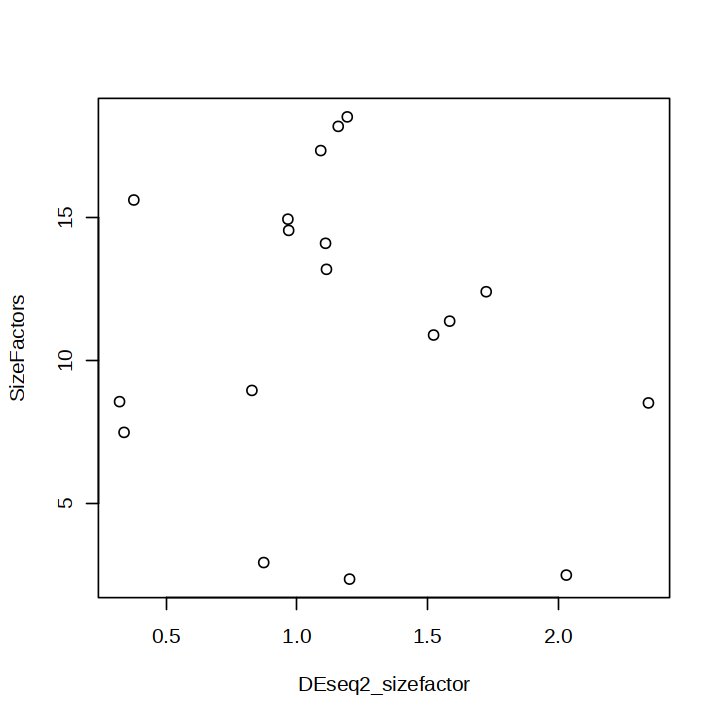

In [390]:
plot(DEseq2_sizefactor,SizeFactors)

In [382]:
SizeFactors.Reciprocal <- 1/SizeFactors

In [383]:
SizeFactors.Reciprocal

Cold_HK1   Cold_HK2   Cold_HK3   Cold_SP1   Cold_SP2   Cold_SP3   Cold_TH1 
0.09189448 0.08797007 0.08066542 0.11694752 0.11755699 0.13376073 0.07586628 
  Cold_TH2   Cold_TH3   Ctrl_HK1   Ctrl_HK2   Ctrl_HK3   Ctrl_SP1   Ctrl_SP2 
0.07096409 0.06876066 0.42701299 0.06407557 0.40280600 0.11180925 0.34231724 
  Ctrl_SP3   Ctrl_TH1   Ctrl_TH2   Ctrl_TH3 
0.06695247 0.05499799 0.05401057 0.05768221

In [481]:
c(atac.tissue_deg_list[["HK"]][[1]]$sizeFactor,atac.tissue_deg_list[["SP"]][[1]]$sizeFactor,atac.tissue_deg_list[["TH"]][[1]]$sizeFactor)

Ctrl_HK1  Ctrl_HK2  Cold_HK1  Cold_HK2  Ctrl_SP1  Ctrl_SP2  Cold_SP1  Cold_SP2 
0.8753716 1.0814143 0.8859635 1.2114555 0.9226684 0.9260776 1.1839785 1.0096695 
 Ctrl_TH1  Ctrl_TH2  Cold_TH1  Cold_TH2 
0.9511700 0.9464322 0.9415778 1.2102101

In [53]:
1/((0.885963512139813 + 1.2114555148422) / 2)

[1] 0.9535529